### Programming Assignment 5: ***Cybersecurity Attack Classification Using Random Forest***
# <span style="color:#00A6F0;">**CYBERSECURITY ATTACK CLASSIFICATION**</span> <img src="cybersec_icon.png" style="width:100px; height:100px; vertical-align:middle">
#### Group Members:
**Bolinas**, Denisse Roxanne H.  
**De Leola**, Miguel S.  
**Ugates**, John Rhey T.  

---

## **Dataset**

### ***Import Neccesary Libraries***

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

---

## **General Guidelines**

### **1. Load and perform exploratory data analysis.**

#### ***Overview of the Dataset***

In [289]:
#Load the Dataset
data = pd.read_csv("cyber_attacks.csv", engine='python', encoding="ISO-8859-1")
data.head()

,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,Botnet
1,1,8.587924,409.971403,710.745376,17,6,Normal
2,1,4.386891,418.478693,559.457816,17,5,Normal
3,0,NaN,NaN,NaN,11,3,Normal
4,0,1.061892,494.253699,572.459614,11,3,Normal


In [290]:
print(data.info())
num_rows, num_columns = data.shape
print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   protocol_type    10000 non-null  int64  
 1   duration         9500 non-null   float64
 2   src_bytes        9500 non-null   float64
 3   dst_bytes        9500 non-null   float64
 4   num_packets      10000 non-null  int64  
 5   num_connections  10000 non-null  int64  
 6   attack_type      10000 non-null  object 
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB
None
Number of Rows: 10000
Number of Columns: 7


#### ***Summary Statistics***

In [291]:
print(data.describe())

       protocol_type     duration    src_bytes    dst_bytes   num_packets  \
count   10000.000000  9500.000000  9500.000000  9500.000000  10000.000000   
mean        0.506100    84.035480   980.541438  1189.719031     93.993200   
std         0.673653   188.084795  1434.835096  1528.620785    147.278664   
min         0.000000     0.000871     0.338156     0.019126      2.000000   
25%         0.000000     4.480702   272.479493   263.080684     14.000000   
50%         0.000000     7.121187   500.910972   598.294521     19.000000   
75%         1.000000    59.675633   776.327886  1021.076731    100.000000   
max         2.000000  1220.385081  8000.795141  7603.412219    582.000000   

       num_connections  
count     10000.000000  
mean         49.757500  
std          94.172701  
min           0.000000  
25%           2.000000  
50%           5.000000  
75%          20.000000  
max         365.000000  


#### ***Checking Missing Values***

In [292]:
missing_count = data.isnull().sum()
missing_percent = (data.isnull().mean() * 100).round(2)
missing_report = pd.DataFrame({'Missing Count': missing_count, 
                              'Missing %': missing_percent})
print("Initial Missing Values Report:")
print(missing_report[missing_count > 0])

Initial Missing Values Report:
           Missing Count  Missing %
duration             500        5.0
src_bytes            500        5.0
dst_bytes            500        5.0


#### ***Remove Missing Values***

In [293]:
initial_count = len(data)
data = data.dropna()
cleaned_count = len(data)
print(f"\nRemoved {initial_count - cleaned_count} rows with missing values")


Removed 500 rows with missing values


In [294]:
assert data.isnull().sum().sum() == 0, "Critical Error: Missing values still exist!"
print("\nMissing values after cleaning:", data.isnull().sum().sum())


Missing values after cleaning: 0


#### ***Visualizing Class Distribution***

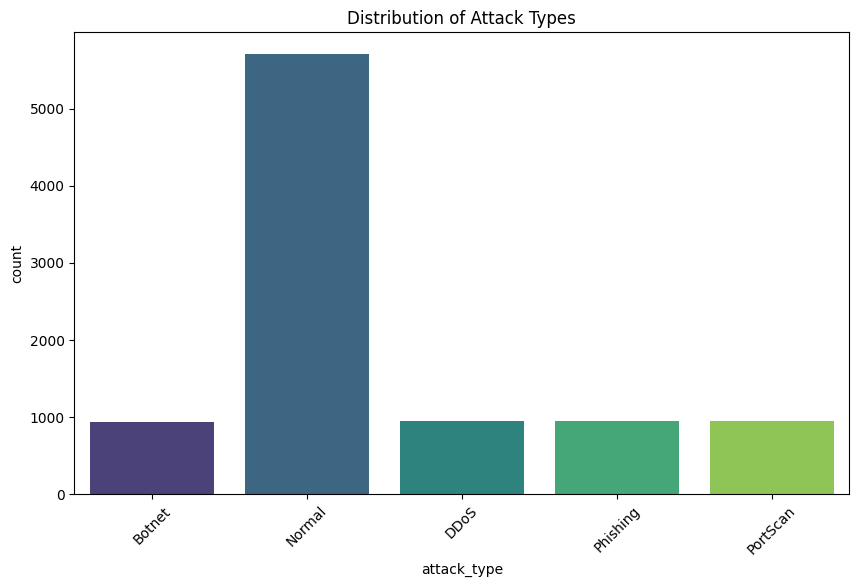

In [295]:
plt.figure(figsize=(10, 6))
sns.countplot(x='attack_type', data=data, hue='attack_type', palette='viridis', legend=False)
plt.title('Distribution of Attack Types')
plt.xticks(rotation=45)
plt.show()

In [296]:
print(data['attack_type'].value_counts(normalize=True))

attack_type
Normal      0.600632
PortScan    0.100421
DDoS        0.100316
Phishing    0.099368
Botnet      0.099263
Name: proportion, dtype: float64


protocol_type
0    5649
1    2880
2     971
Name: count, dtype: int64


<Axes: xlabel='duration', ylabel='Count'>

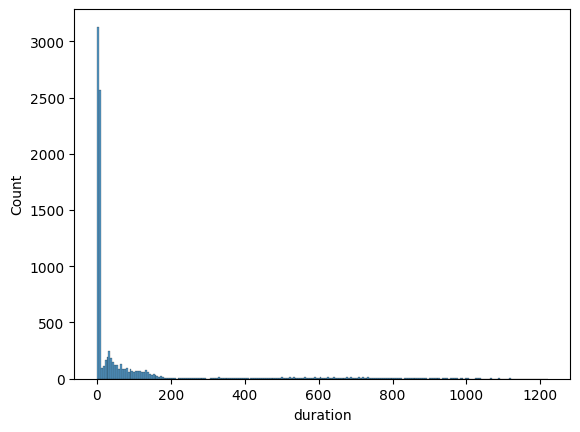

In [297]:
print(data['protocol_type'].value_counts())
sns.histplot(data['duration'])

***CORRELATION MATRIX***

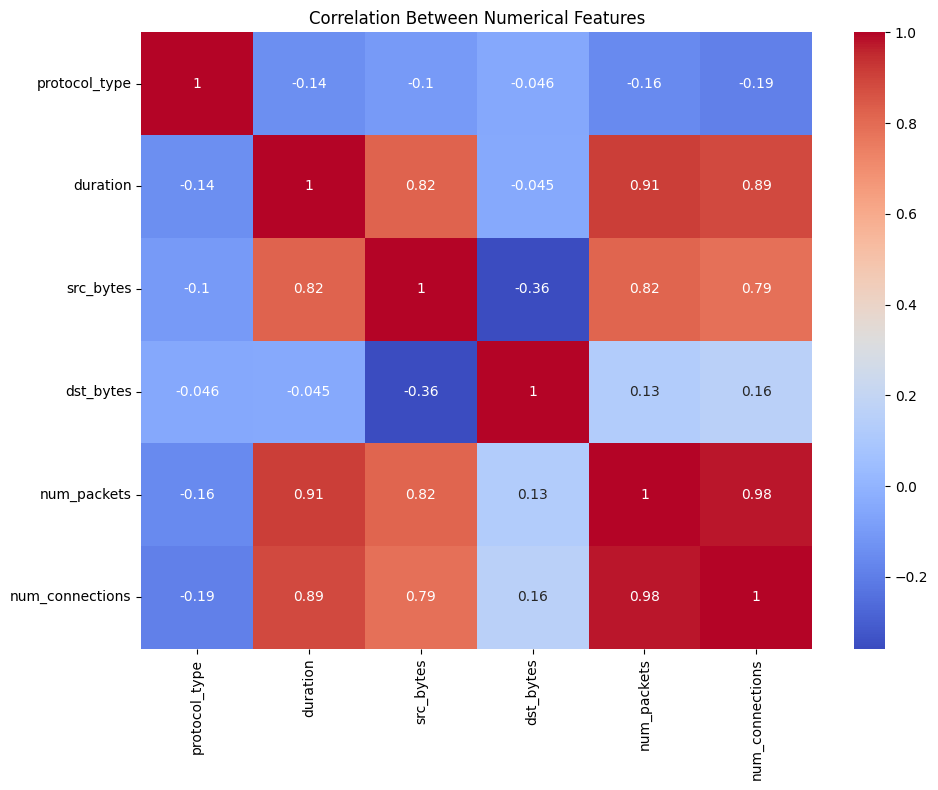

In [298]:
# If protocol_type is categorical (strings), exclude it from correlation analysis
if data['protocol_type'].dtype == 'object':
    numeric_features = ['duration', 'src_bytes', 'dst_bytes', 'num_packets', 'num_connections']
    correlation = data[numeric_features].corr()
else:
    numeric_features = ['protocol_type', 'duration', 'src_bytes', 'dst_bytes', 'num_packets', 'num_connections']
    correlation = data[numeric_features].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Between Numerical Features')
plt.tight_layout()
plt.show()

***DISTRIBUTION OF ALL NUMERIC FEATURES***

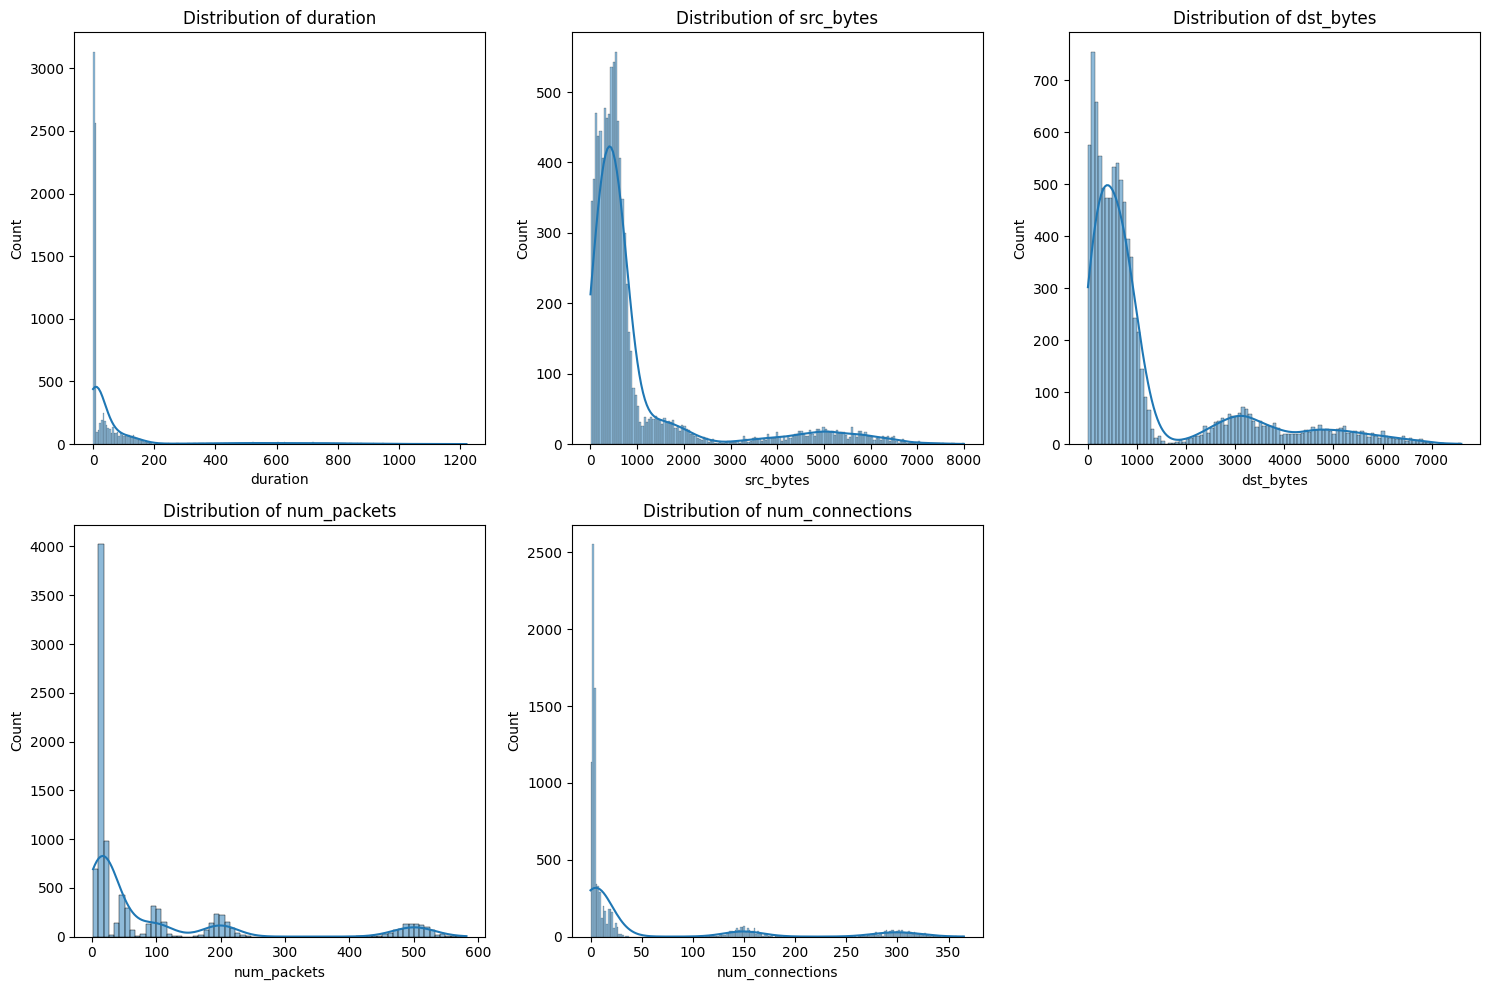

In [299]:
# Distribution of all numeric features
numeric_features = ['duration', 'src_bytes', 'dst_bytes', 'num_packets', 'num_connections']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

***OUTLIER DETECTION***

*FEATURE DISTRIBUTION BY ATTACK TYPE*

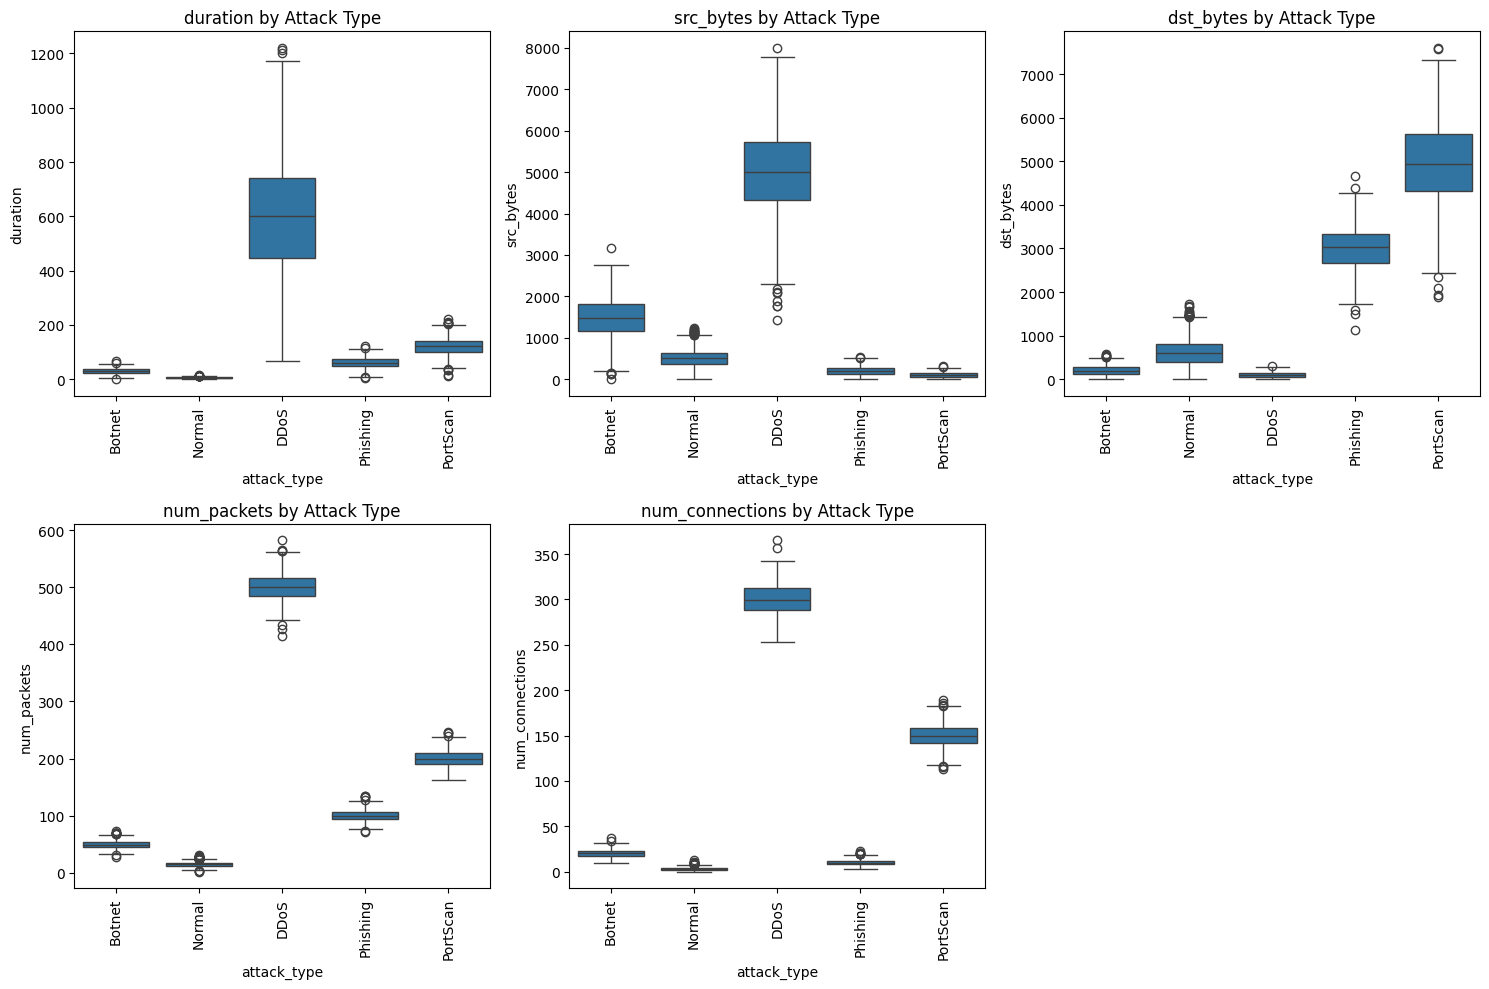

In [300]:
# Feature distributions by attack type
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='attack_type', y=feature, data=data)
    plt.title(f'{feature} by Attack Type')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

*Relationship Between Multiple Variables*

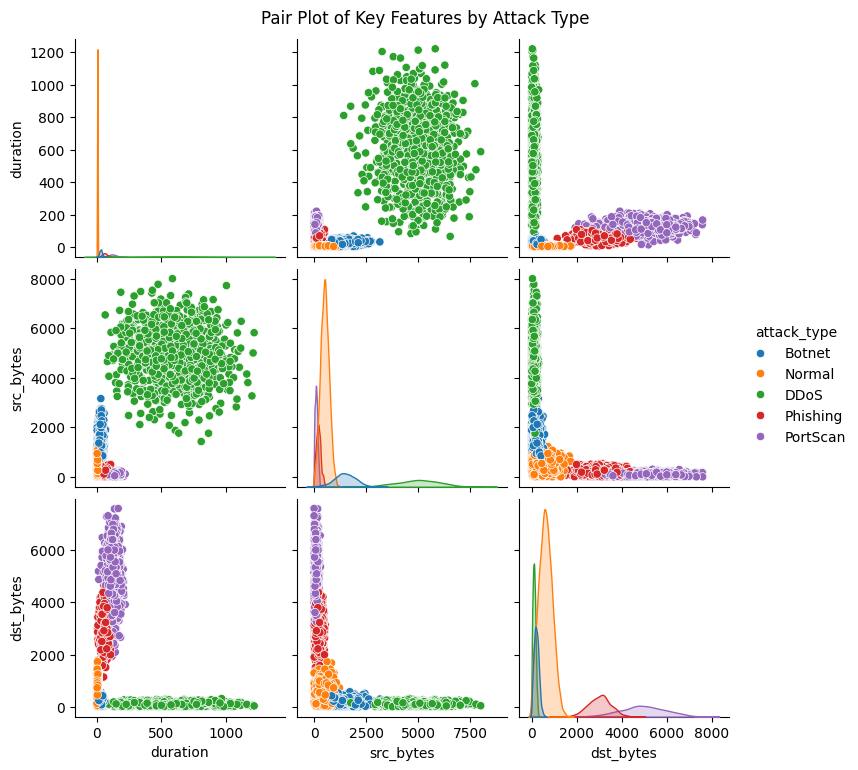

In [301]:
# Pair plot (limit to a subset of features to avoid overcrowding)
sns.pairplot(data[numeric_features[:3] + ['attack_type']], hue='attack_type')
plt.suptitle('Pair Plot of Key Features by Attack Type', y=1.02)
plt.show()

---

### **2. Perform data preprocessing.**

#### ***Encoding Categorical Features***

In [302]:
categorical_features = ['protocol_type']
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

#### ***Scaling Categorical Features***

In [303]:
numerical_features = ['duration', 'src_bytes', 'dst_bytes', 'num_packets', 'num_connections']
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

#### ***Preprocessing Pipeline***

In [304]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#### ***Splitting the Dataset***

In [305]:
X = data.drop(columns=['attack_type'])
y = data['attack_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#### ***Handling Class Imbalance***

In [306]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

---

### **3. Train a Random Forest Classifier using the preprocessed data to train the model.**

#### ***With Protocol***

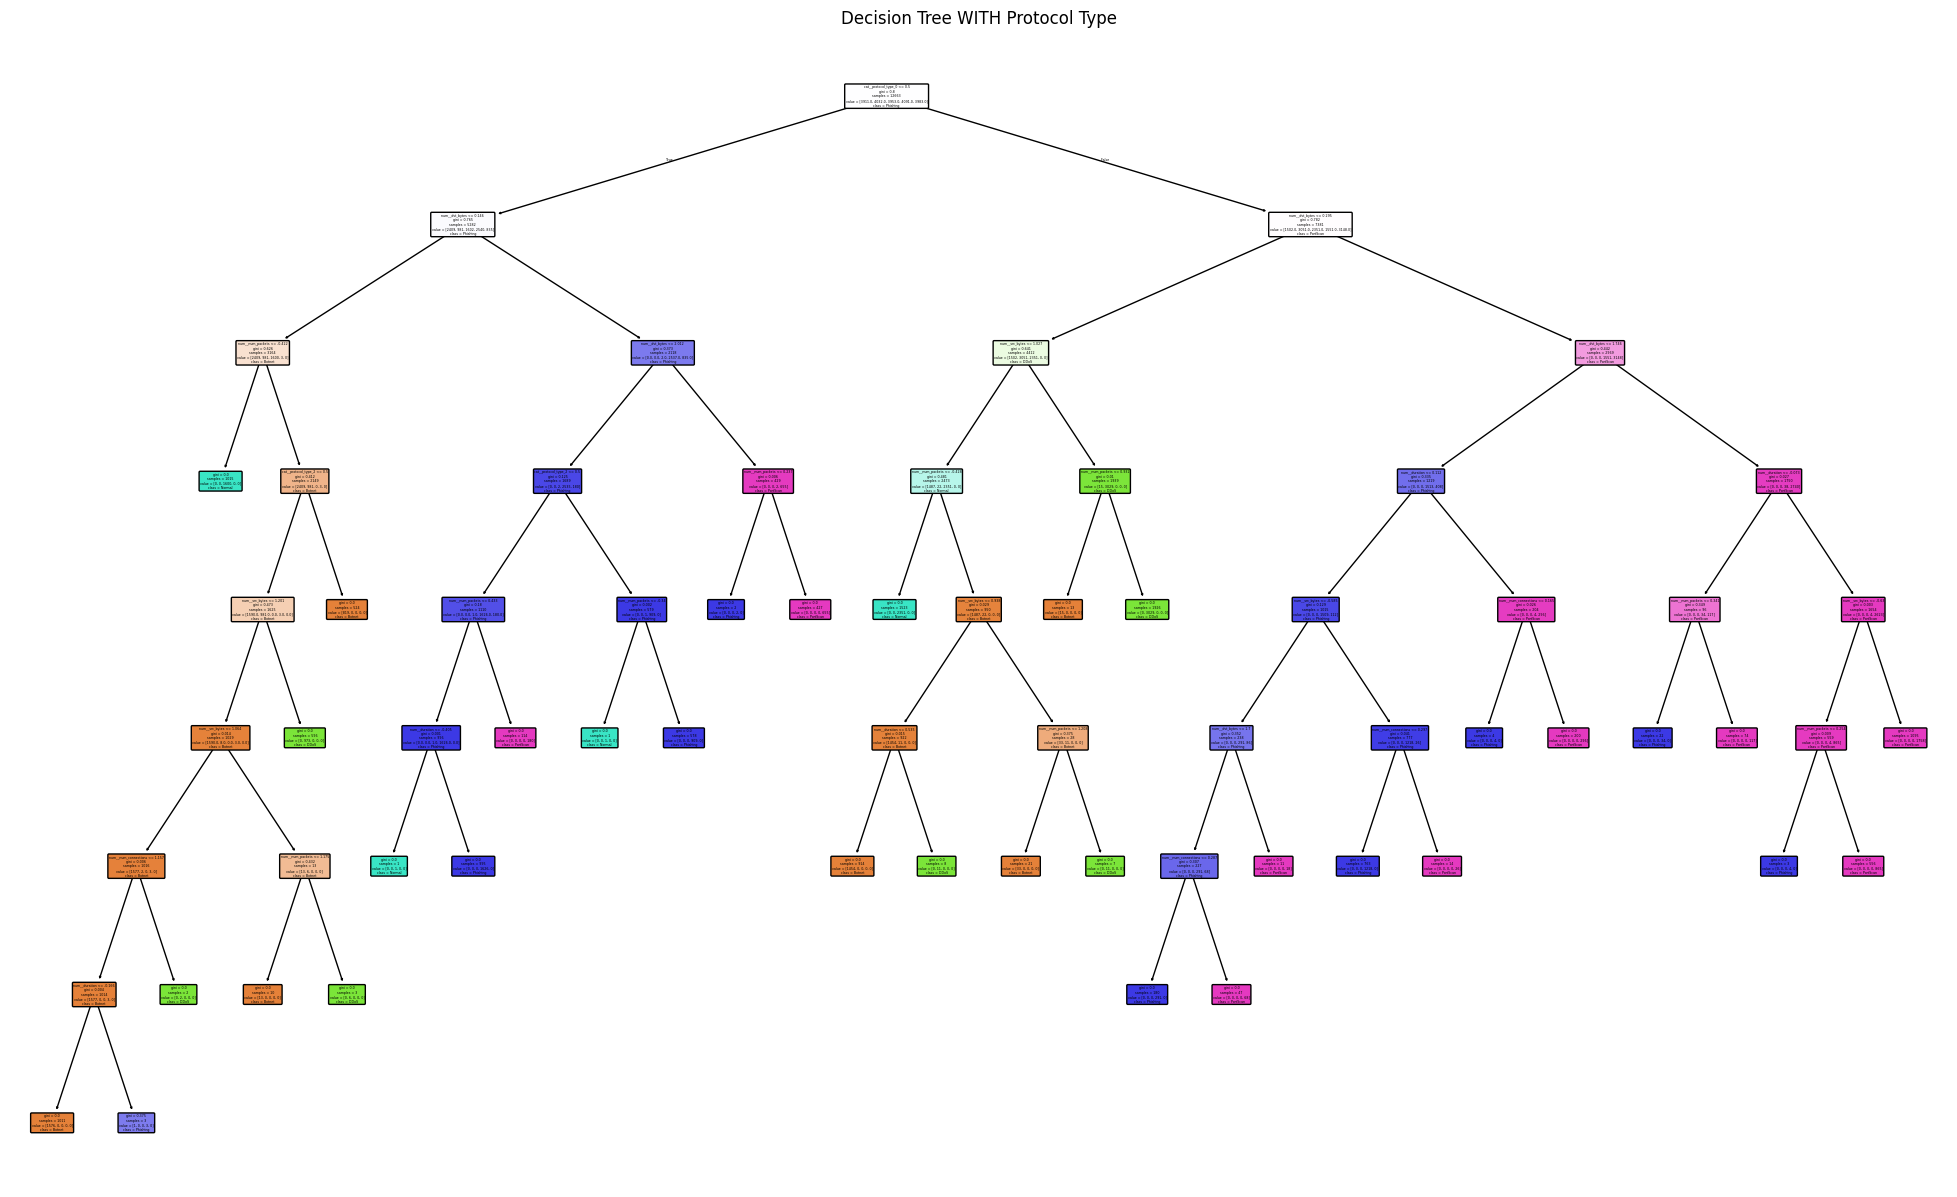

In [307]:
rf_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    ))
])

# Train with original split
rf_pipeline.fit(X_train, y_train)  # Not using X_train_resampled

# Visualize tree with protocol_type
plt.figure(figsize=(25, 15))
plot_tree(rf_pipeline.named_steps['classifier'].estimators_[0],
          feature_names=rf_pipeline.named_steps['preprocessor'].get_feature_names_out(),
          class_names=rf_pipeline.classes_,
          filled=True,
          rounded=True,) 
plt.title('Decision Tree WITH Protocol Type')
plt.show()

#### ***Without Protocol***

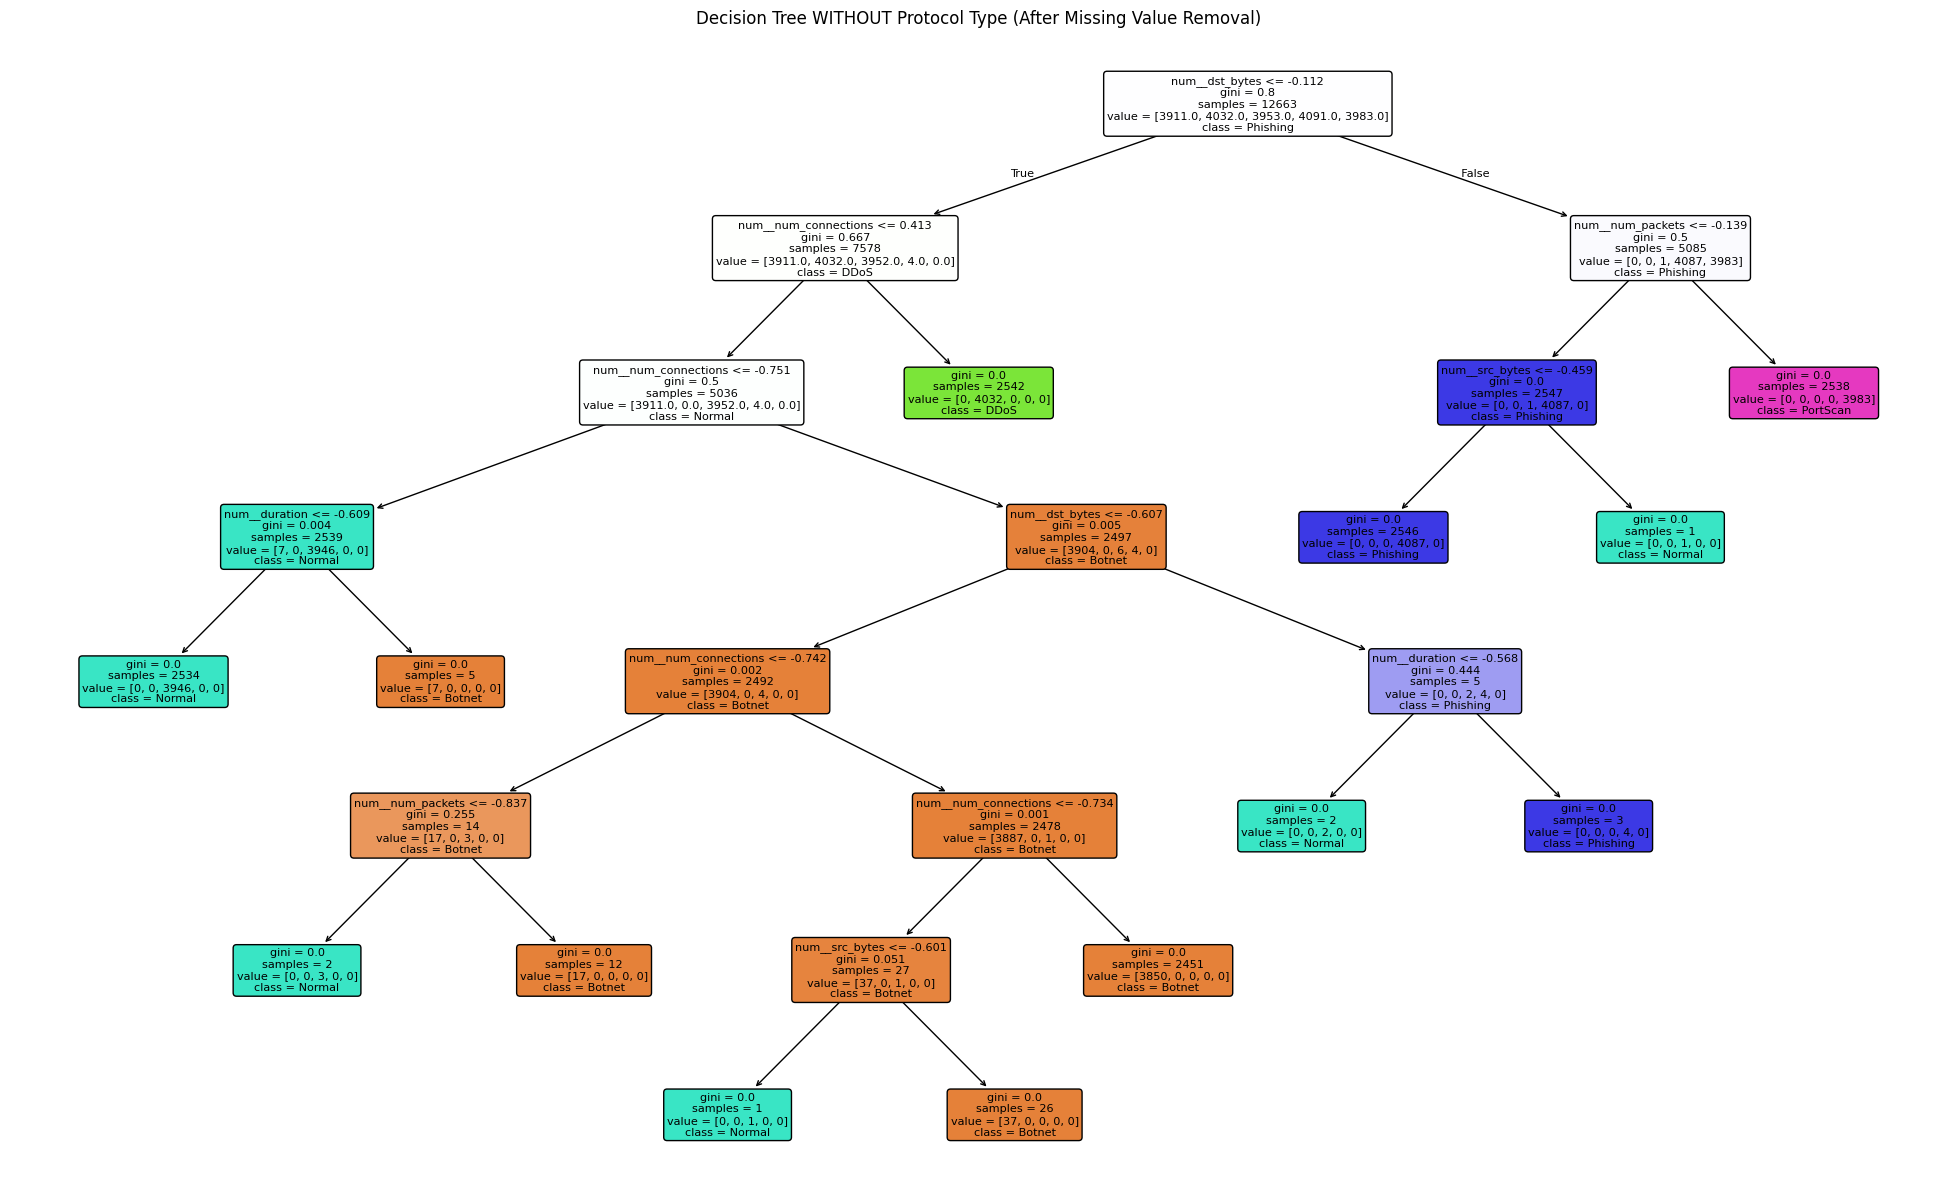

In [308]:
X_train_no_protocol = X_train.drop(columns=['protocol_type'])
smote = SMOTE(random_state=42)
X_train_res_no_protocol, y_train_res_no_protocol = smote.fit_resample(X_train_no_protocol, y_train)

# Define preprocessing WITHOUT protocol_type
preprocessor_without_protocol = ColumnTransformer(
    transformers=[('num', numerical_transformer, numerical_features)]
)

# Train pipeline
rf_pipeline_without_protocol = ImbPipeline([
    ('preprocessor', preprocessor_without_protocol),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    ))
])

# Train on same cleaned/resampled data
rf_pipeline_without_protocol.fit(X_train_res_no_protocol, y_train_res_no_protocol)

# Visualize tree without protocol_type
plt.figure(figsize=(25, 15))
plot_tree(rf_pipeline_without_protocol.named_steps['classifier'].estimators_[0],
          feature_names=preprocessor_without_protocol.get_feature_names_out(),
          class_names=rf_pipeline_without_protocol.classes_,
          filled=True,
          rounded=True)
plt.title('Decision Tree WITHOUT Protocol Type (After Missing Value Removal)')
plt.show()

---

### **4. Perform feature importance analysis.**

#### ***With Protocol***

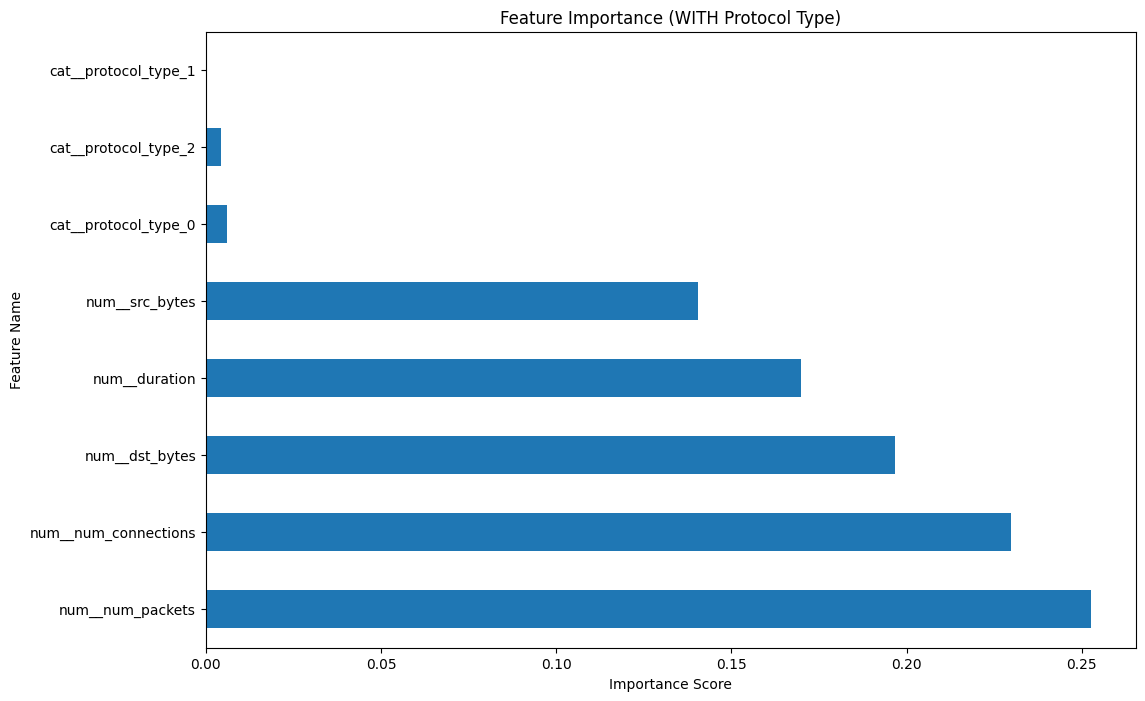

In [309]:
importances = rf_pipeline.named_steps['classifier'].feature_importances_
features = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

plt.figure(figsize=(12, 8))
pd.Series(importances, index=features).sort_values(ascending=False).head(10).plot.barh()
plt.title('Feature Importance (WITH Protocol Type)')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()


In [310]:
print("\nFeature Importances (WITH Protocol):")
for feature, importance in sorted(zip(features_with, importances_with), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")


Feature Importances (WITH Protocol):
num__num_packets: 0.2527
num__num_connections: 0.2296
num__dst_bytes: 0.1967
num__duration: 0.1699
num__src_bytes: 0.1404
cat__protocol_type_0: 0.0060
cat__protocol_type_2: 0.0043
cat__protocol_type_1: 0.0004


#### ***Without Protocol***

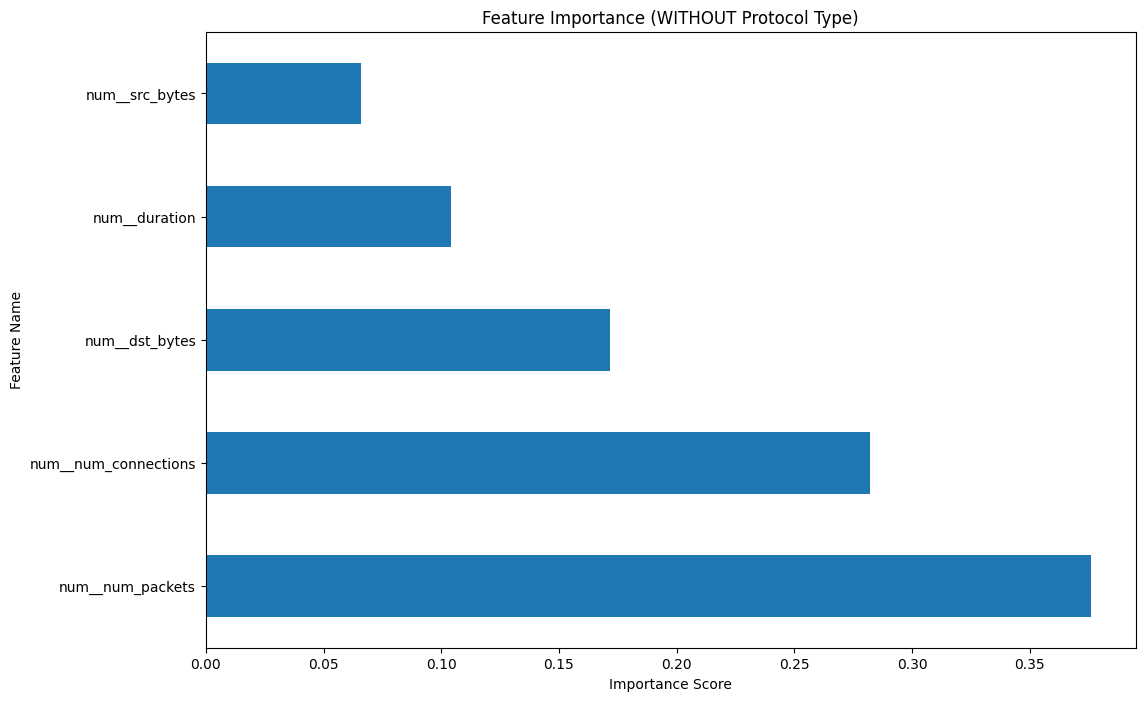

In [311]:
importances_without = rf_pipeline_without_protocol.named_steps['classifier'].feature_importances_
features_without = rf_pipeline_without_protocol.named_steps['preprocessor'].get_feature_names_out()

plt.figure(figsize=(12, 8))
pd.Series(importances_without, index=features_without).sort_values(ascending=False).head(10).plot.barh()
plt.title('Feature Importance (WITHOUT Protocol Type)')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

In [312]:
print("\nFeature Importances (WITHOUT Protocol):")
for feature, importance in sorted(zip(features_without, importances_without), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")


Feature Importances (WITHOUT Protocol):
num__num_packets: 0.3761
num__num_connections: 0.2820
num__dst_bytes: 0.1715
num__duration: 0.1043
num__src_bytes: 0.0661


---

### **5. Evaluate the model performance and report precision, recall, and F1-score.**

#### ***With Protocol***

In [313]:
y_pred_with = rf_pipeline.predict(X_test)
print("\n================= Model WITH Protocol =================")
print(classification_report(y_test, y_pred_with))


================= Model WITH Protocol =================
              precision    recall  f1-score   support

      Botnet       1.00      1.00      1.00       283
        DDoS       1.00      1.00      1.00       286
      Normal       1.00      1.00      1.00      1712
    Phishing       1.00      1.00      1.00       283
    PortScan       1.00      1.00      1.00       286

    accuracy                           1.00      2850
   macro avg       1.00      1.00      1.00      2850
weighted avg       1.00      1.00      1.00      2850



#### ***Without Protocol***

In [315]:
#Drop protocol_type upfront
X_no_protocol = data.drop(columns=['attack_type', 'protocol_type'])
y = data['attack_type']

#Evaluate
y_pred_np = rf_pipeline_np.predict(X_test_np)
print("\n================= Model WITHOUT Protocol =================")
print(classification_report(y_test_np, y_pred_np))


================= Model WITHOUT Protocol =================
              precision    recall  f1-score   support

      Botnet       1.00      1.00      1.00       283
        DDoS       1.00      1.00      1.00       286
      Normal       1.00      1.00      1.00      1712
    Phishing       1.00      1.00      1.00       283
    PortScan       1.00      1.00      1.00       286

    accuracy                           1.00      2850
   macro avg       1.00      1.00      1.00      2850
weighted avg       1.00      1.00      1.00      2850



**Note:** Both models achieved perfect accuracy, meaning `protocol_type` does not impact classification. Other features fully separate the classes, making `protocol_type` redundant in this dataset. In real-world cases, protocol might matter, but here, it's not a key factor.


---

## **Guide Questions**

### **1. Preprocessing**

- #### **How did you handle missing values in numerical features?**

Rows with missing values in numerical features were removed rather than imputing them since we wanted to maintain the integrity of the dataset without introducing artifical values. This approach also helps avoid potential biases that could arise from imputation, especially when dealing with cybersecurity data where missing values might indicate anomalies. This ensures that the dataset does not contain any missing values before further processing.

- #### **Why is there a need to encode `protocol_type` feature, and which encoding method can be used?**

The `protocol_type` feature needed to be encoded because it is categorical, and machine learning models like Random Forest require numerical input. We used One-Hot Encoding (OHE) since it converts each category into separate binary columns without imposing an artificial order, which makes it the most suitable method for nominal categorical data.

---

### **2. Model Training**

- #### **How did you address class imbalance in the dataset?**

Class imbalance was addressed using the Synthetic Minority Over-sampling Technique (SMOTE). We utilized this since it generates synthetic samples for the minority class to ensure that the model does not become biased towards the majority class. Hence, `SMOTE` was applied before training the Random Forest classifier to create a balanced dataset.

- #### **What hyperparameters of the Random Forest did you tune, and why?**

The hyperparameters tuned for the Random Forest were the following:
- `n_estimators`: Set to 200 to ensure a sufficient number of trees for better performance and stability.
- `max_depth`: Set to 15 to control the depth of each tree, preventing overfitting.
- `min_samples_split`: Set to 5 to ensure that nodes are split only if they have at least 5 samples, which helps in reducing overfitting.
- `class_weight`: Set to 'balanced' to handle class imbalance by adjusting weights inversely proportional to class frequencies.
- `random_state`: Set to 42 to ensure reproducibility of results.

- #### **Why is a pipeline useful for this task?**

A pipeline is useful for this task because it makes the workflow efficient by combining together multiple preprocessing steps and the model training process. This ensures that all steps were executed in the correct order and that the same transformations are applied consistently to both the training and test data. Moreover, this helps in simplifying the code to make it more readable and it reduces the risk of data leakage by encapsulating the entire process within a single object.

---

### **3. Evaluation**

- #### **Why is accuracy alone insufficient to evaluate this model?**

Accuracy alone is insufficient to evaluate this model since it does not account for class imbalance. In a dataset with imbalanced classes, a model could achieve high accuracy by simply predicting the majority class most of the time, while failing to correctly classify the minority classes. Hence, this would give a false sense of model performance so, precision, recall, and F1-score provide a more comprehensive evaluation by considering the performance on both majority and minority classes to ensure that the model is eefective across all types of attacks.

**Which attack type was hardest to classify, and why might this be?**

Based on the classification report, all attack types were classified with perfect precision, recall, and F1-score.

- #### **How would you improve the model’s performance on minority classes?**

To improve the model's performance on minority classes, using advanced resampling techniques like ADASYN or SMOTE-ENN, adjusting class weights in the RandomForestClassifier, performing feature engineering, using ensemble methods like Balanced Random Forest, conducting extensive hyperparameter tuning with GridSearchCV or RandomizedSearchCV, incorporating anomaly detection techniques, and augmenting the dataset with domain-specific knowledge or simulated data can be considered.

---

### **4. Interpretation**

- #### **Which features were most important for classification? Does this align with real-world attack patterns?**

The most important features for classification were `num_packets`, `num_connections`, and `dst_bytes`. These features align well with real-world attack patterns as follows:
- `num_packets`: High packet counts can indicate scanning or flooding attacks.
- `num_connections`: A large number of connections can be a sign of DDoS attacks.
- `dst_bytes`: The amount of data sent to the destination can help identify data exfiltration or large-scale data transfers typical in certain attacks.

- #### **How would you explain the model’s decision-making process to a non-technical team?**

To explain the model's decision-making process to a non-technical team, we can use an analogy.

The model works like an experienced security guard who recognizes cyber threats based on patterns in network traffic. It examines key indicators like connection duration, packet count, and data transfer volume to identify suspicious activity. For instance, numerous rapid connections might signal a DDoS attack, while large data transfers to unknown destinations could indicate data theft. Hence, the model relies on historical training data of both normal and malicious activities to make informed decisions when encountering new situations.

---

### **5. Application**

- #### **What steps would you take to deploy this model in a real-time network monitoring system?**

To deploy this model in a real-time network monitoring system, we would follow several steps. First, we would serialize the learned model using `joblib` or `pickle`. Next, we would create a RESTful API for predictions using Flask or FastAPI to ensure that the preprocessing of incoming data is identical to that done during training. We would set up real-time data ingestion using tools such as Kafka and create an API endpoint to collect information and provide forecasts. Monitoring API performance and usage, and keeping an eye out for irregularities, would be crucial. We would implement HTTPS and put authorization and authentication into practice to secure the system. For deployment, we would use cloud services or scalable infrastructure, such as Kubernetes. Additionally, we would set up CI/CD pipelines for automated testing and deployment. Finally, to maintain model accuracy, we would periodically retrain the model using fresh data.

- #### **How would you handle new attack types not present in the training data?**

In order to handle new attack types that are not present in the training data, we can use anomaly detection techniques. One approach is to train an anomaly detection model on the normal traffic data, which can then flag any new, unseen attack types as anomalies. Additionally, we can periodically retrain the Random Forest model with new data that includes the new attack types to improve its ability to recognize them to keep the model up-to-date and accurately classify new types of attacks.

---